In [ ]:
!pip install selenium==4.10.0 textblob joblib python-dotenv webdriver-manager scikit-learn pandas
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

In [ ]:
from selenium import webdriver

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.add_argument("--disable-blink-features=AutomationControlled")
chrome_options.add_argument("--window-size=1920,1080")

# Use this when initializing the driver:
# driver = webdriver.Chrome(options=chrome_options)

In [ ]:
USERNAME = "your_x_username"
PASSWORD = "your_password"
EMAIL = "your_email@example.com"

In [ ]:
username = input("Enter X.com username (without @): ")

In [ ]:
# Uninstall preinstalled chromium
!apt remove chromium-browser -y

# Install Chromium version 114
!wget https://storage.googleapis.com/chrome-for-testing-public/114.0.5735.90/linux64/chrome-linux64.zip
!unzip chrome-linux64.zip
!mv chrome-linux64 /opt/chrome

# Install matching Chromedriver
!wget https://storage.googleapis.com/chrome-for-testing-public/114.0.5735.90/linux64/chromedriver-linux64.zip
!unzip chromedriver-linux64.zip
!mv chromedriver-linux64/chromedriver /opt/chrome/chromedriver
!chmod +x /opt/chrome/chromedriver


In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service

chrome_options = webdriver.ChromeOptions()
chrome_options.binary_location = "/opt/chrome/chrome"
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.add_argument("--disable-blink-features=AutomationControlled")
chrome_options.add_argument("--window-size=1920x1080")

driver = webdriver.Chrome(service=Service("/opt/chrome/chromedriver"), options=chrome_options)


In [ ]:
import pandas as pd
import numpy as np
import joblib
from textblob import TextBlob
import re
import time
import requests
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Credentials (replace or use getpass as shown above)
USERNAME = "your_username"
PASSWORD = "your_password"
EMAIL = "your_email"

# Utility functions
def extract_int(text):
    text = text.replace(",", "").lower()
    match = re.search(r'(\d+\.?\d*)([km]?)', text)
    if match:
        number = float(match.group(1))
        return int(number * 1_000) if match.group(2) == 'k' else int(number * 1_000_000) if match.group(2) == 'm' else int(number)
    return 0

def get_sentiment(text):
    return int(np.sign(TextBlob(text).sentiment.polarity)) if text else 0

# Model training (do this once)
def train_and_save_models():
    df1 = pd.read_csv("/content/data file.csv").fillna(0)
    X1 = df1[["is_verified", "following_count", "followers_count", "is_default_profile_image"]]
    y1 = df1["is_spam_account"]
    rf_model = RandomForestClassifier(class_weight='balanced', random_state=0)
    rf_model.fit(X1, y1)
    joblib.dump(rf_model, "model_rf.pkl")

    df2 = pd.read_csv("dataspam.csv").fillna(0)
    X2 = df2[["identical_tweet_freq"]]
    y2 = df2["is_spam_account"]
    log_model = LogisticRegression()
    log_model.fit(X2, y2)
    joblib.dump(log_model, "model_logistic.pkl")

# Run this only once:
train_and_save_models()

# Load pre-trained models
model_rf = joblib.load("model_rf.pkl")
model_log = joblib.load("model_logistic.pkl")

# Define X1 and y1 globally for metrics calculation
df1 = pd.read_csv("/content/data file.csv").fillna(0)
X1 = df1[["is_verified", "following_count", "followers_count", "is_default_profile_image"]]
y1 = df1["is_spam_account"]


def login_to_x(driver):
    driver.get("https://x.com/login")
    WebDriverWait(driver, 15).until(EC.presence_of_element_located((By.NAME, "text"))).send_keys(USERNAME)
    driver.find_element(By.XPATH, "//span[contains(text(),'Next')]").click()
    time.sleep(2)
    try:
        WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.NAME, "text"))).send_keys(EMAIL)
        driver.find_element(By.XPATH, "//span[contains(text(),'Next')]").click()
    except: pass
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.NAME, "password"))).send_keys(PASSWORD)
    driver.find_element(By.XPATH, "//span[contains(text(),'Log in')]").click()
    time.sleep(5)

def get_user_features(username):
    driver = webdriver.Chrome(options=chrome_options)
    try:
        login_to_x(driver)
        driver.get(f"https://x.com/{username}")
        time.sleep(6)

        is_verified = int(bool(driver.find_elements(By.CSS_SELECTOR, "svg[data-testid='icon-verified']")))
        try:
            bio = driver.find_element(By.CSS_SELECTOR, "div[data-testid='UserDescription']").text
        except: bio = ""
        profile_sentiment = get_sentiment(bio)

        following = followers = 0
        for stat in driver.find_elements(By.XPATH, "//a[contains(@href, '/followers') or contains(@href, '/following')]"):
            if "Following" in stat.text:
                following = extract_int(stat.text)
            elif "Followers" in stat.text:
                followers = extract_int(stat.text)

        tweets = [t.text for t in driver.find_elements(By.CSS_SELECTOR, "div[data-testid='tweetText']")]
        identical_freq = round((len(tweets) - len(set(tweets))) / len(tweets), 2) if tweets else 0

        try:
            img_url = driver.find_element(By.CSS_SELECTOR, "img[alt*='Image']").get_attribute("src")
            is_default_img = int("default_profile" in img_url)
        except:
            is_default_img = 1

        return [is_verified, profile_sentiment, following, followers, is_default_img, identical_freq]
    except Exception as e:
        print("Scraping error:", e)
        return None
    finally:
        driver.quit()

def predict_bot(features, username):
    main_features = [features[i] for i in [0, 2, 3, 4]]
    if model_rf.predict([main_features])[0] == 1:
        if model_log.predict([[features[5]]])[0] == 1:
            return f"'{username}' is a Spam Bot!"
        else:
            return f"'{username}' is a Non-Spam Bot."
    return f"'{username}' seems like a Human User."

# Run the detection
username = input("Enter X.com username (without @): ")
features = get_user_features(username)
if features:
    result = predict_bot(features, username)
    print("Result:", result)
else:
    print("Failed to fetch or process user data.")

In [13]:
from sklearn.metrics import confusion_matrix

y_true = y1
y_pred = model_rf.predict(X1)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[58  0]
 [ 0 42]]


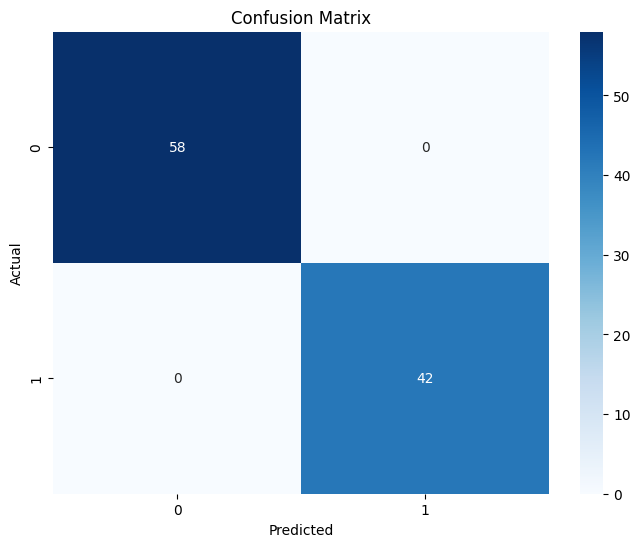

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


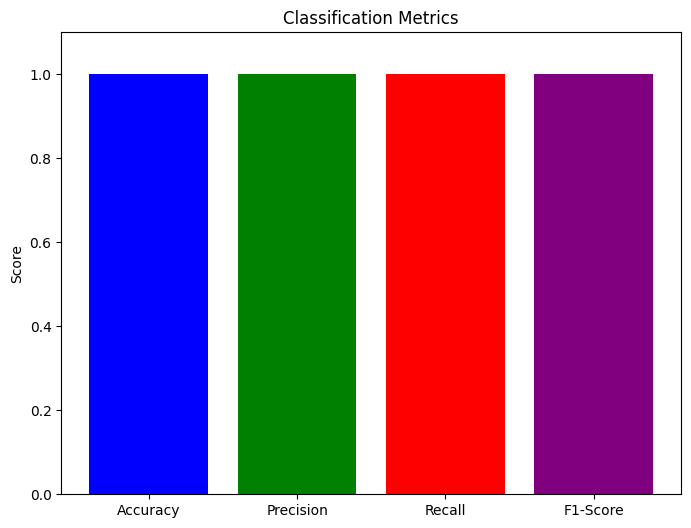

In [16]:
import matplotlib.pyplot as plt
import numpy as np

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1.1) # Set y-axis limit slightly above 1 for better visualization
plt.ylabel('Score')
plt.title('Classification Metrics')
plt.show()